In [1]:
import os
import warnings
warnings.filterwarnings("ignore")

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
import graphviz
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import random
import seaborn as sns
import tensorflow as tf
from tqdm import tqdm

from tensorflow.keras import Input
from keras.layers import Activation, Dense, Dropout
from keras.models import Sequential
from keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from matplotlib import rcParams

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import (
    BaggingClassifier,
    ExtraTreesClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
    RandomTreesEmbedding,
    VotingClassifier,
)
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import (
    KFold,
    StratifiedKFold,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBClassifier

2025-09-29 21:58:51.991160: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759183132.256395      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759183132.328076      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Project Topic

This project is about trying to predict passenger survivorship based on data about the passengers on the Titanic.
I will be utilizing Neural Networks to create a model that makes the prediction. This is a logistic regression task.

## Project Goals

The goal of the project is to have practice with Neural Networks and develop my skills with hyperparameter tuning. As a history lover and tech enthusiast, this dataset will be fun to work with and provide an opportunity for me to compare many different Machine Learning algorithms. I want to see side-by-side how Deep Learning compares to Supervised/Unsupervised Learning in small datasets like this one.

# Data

Source: https://www.kaggle.com/competitions/titanic/data

This data is public and comes from Kaggle.

In [3]:
df_train = pd.read_csv("../input/titanic/train.csv")
df_test = pd.read_csv("../input/titanic/test.csv")

## Data Info and Size

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
df_train.head(25)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [7]:
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


# Exploratory Data Analysis

I will now plot distribuion of values in all categories as well as their relation to the target variable.

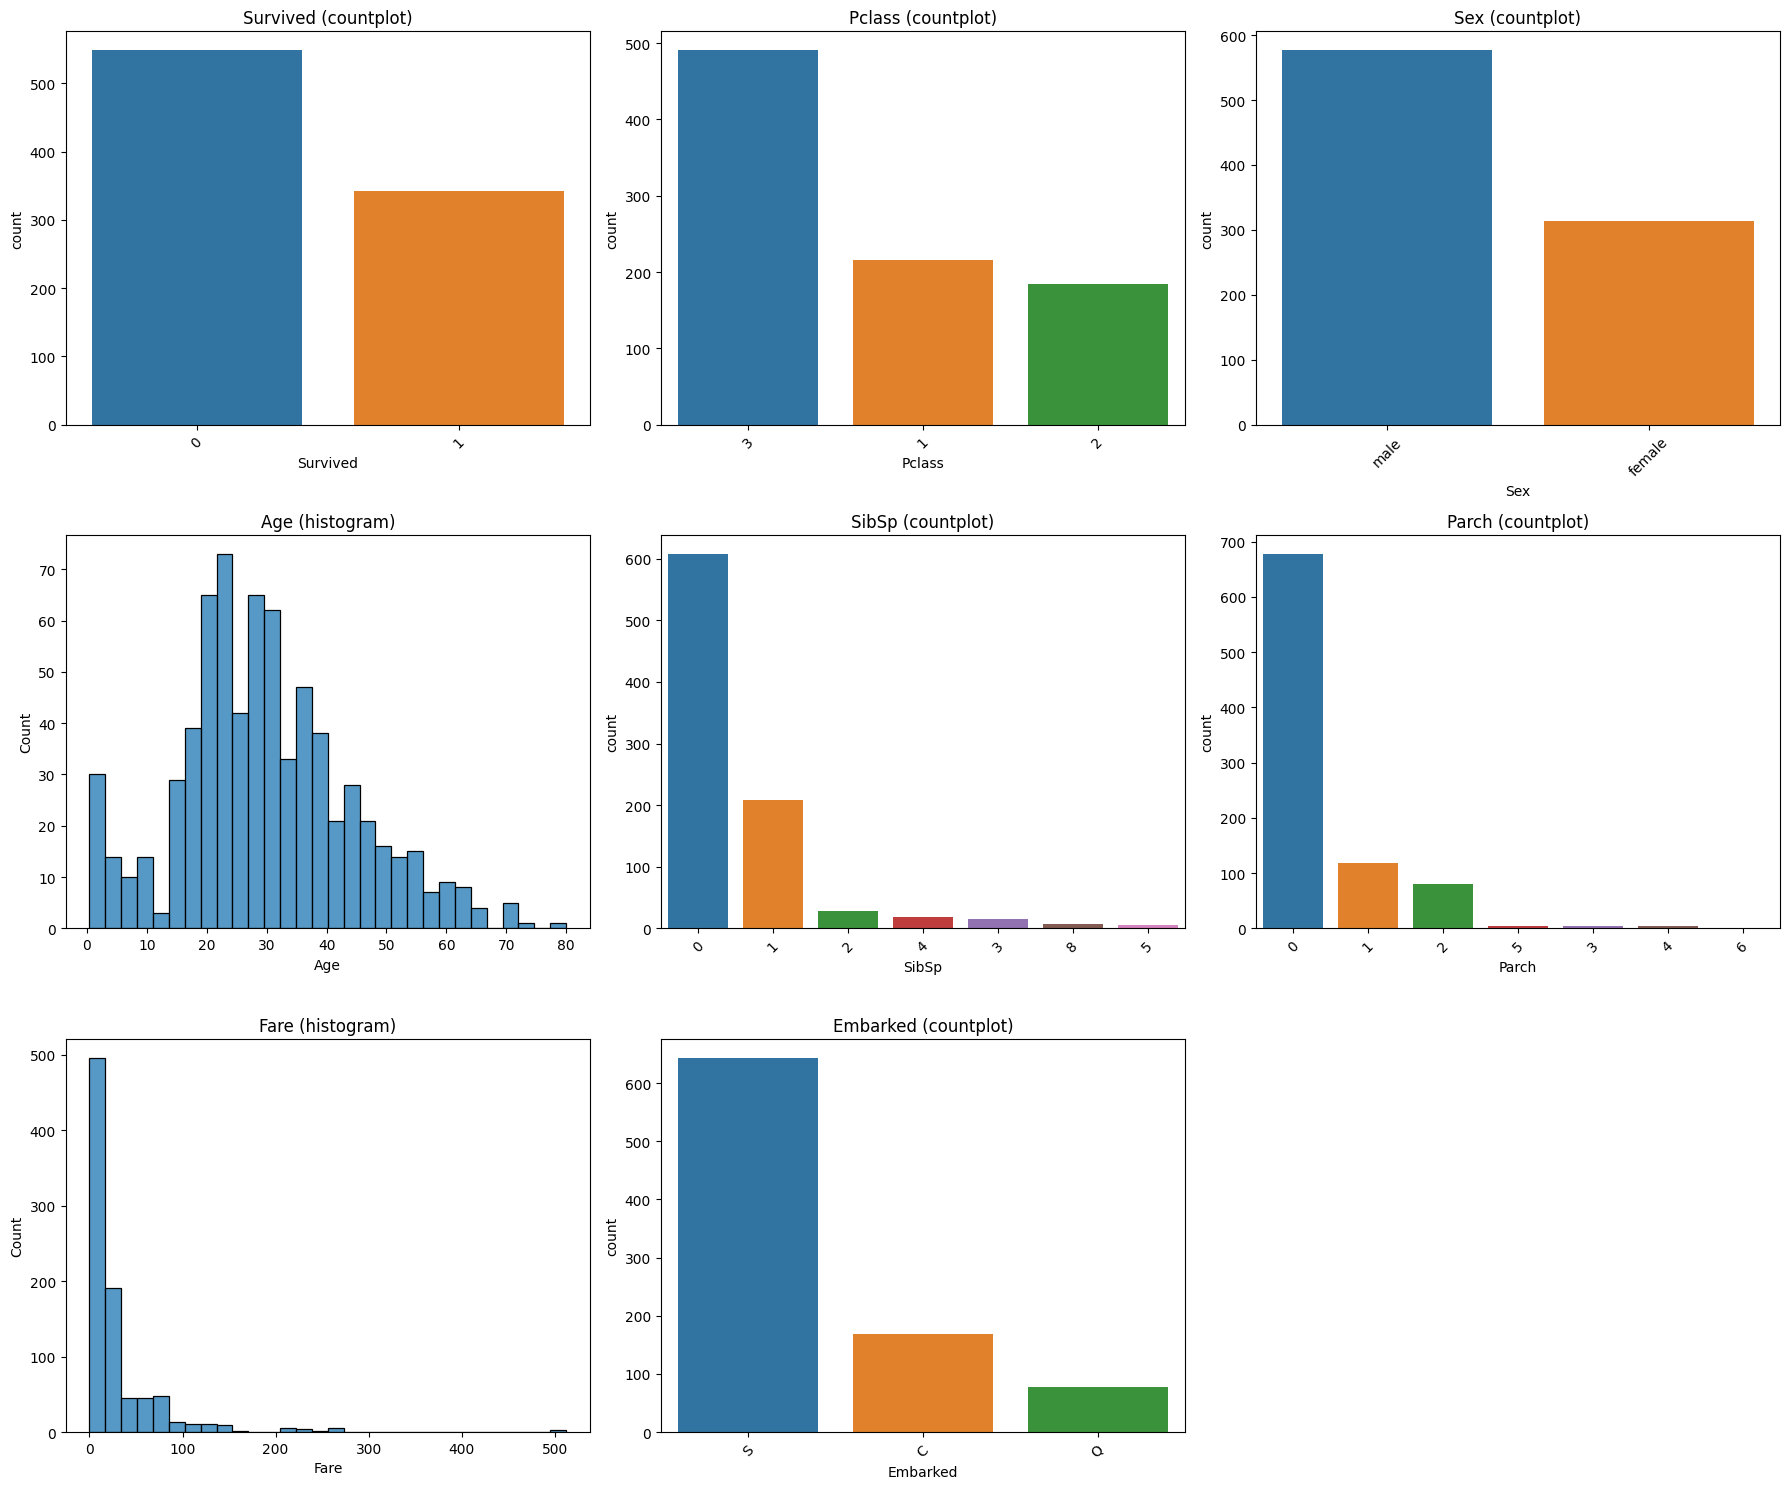

In [8]:
def plot_column_values(df, max_unique=15, skip_high_cardinality=True):
    """
    Plots value distributions for each column in the dataframe.
    - For numeric columns: histogram
    - For categorical/low-cardinality columns: countplot
    - Skips high-cardinality columns like Name/Ticket if skip_high_cardinality=True
    """
    cols_to_plot = []
    for col in df.drop(columns=["PassengerId"]).columns:
        if skip_high_cardinality and df[col].nunique() > max_unique and df[col].dtype == "object":
            continue
        cols_to_plot.append(col)

    n_cols = 3
    n_rows = int(np.ceil(len(cols_to_plot) / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
    axes = axes.flatten()

    for i, col in enumerate(cols_to_plot):
        ax = axes[i]
        if df[col].dtype == "object" or df[col].nunique() <= max_unique:
            sns.countplot(x=col, data=df, ax=ax, order=df[col].value_counts().index)
            ax.set_title(f"{col} (countplot)")
            ax.tick_params(axis="x", rotation=45)
        else:
            sns.histplot(df[col].dropna(), bins=30, kde=False, ax=ax)
            ax.set_title(f"{col} (histogram)")

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

plot_column_values(df_train)

**Survived**

When I look at the Survived column, I see that more passengers did not survive than those who did. This tells me the dataset is imbalanced, with survival being the minority class.

**Pclass**

The distribution of Pclass shows that most passengers were in 3rd class, while fewer were in 1st class. This suggests that socio-economic status could have had an impact on survival.

**Sex**

The Sex column is roughly balanced between male and female, but slightly more males are present. Since gender is known to affect survival rates, I expect this feature to be highly predictive.

**Age**

The Age histogram shows a concentration of passengers in their 20s and 30s, with a long tail into older ages. There are also some children on board, which might influence survival differently compared to adults.

**SibSp**

Most passengers traveled alone or with one sibling/spouse. Very few had large numbers of siblings or spouses, which suggests that being part of a large group was uncommon.

**Parch**

The Parch column shows that most passengers did not have parents or children with them. A smaller group traveled with one or two relatives, while large families were rare.

**Fare**

The Fare histogram is right-skewed, with most fares being low and a few passengers paying very high prices. This reflects the socio-economic diversity of the passengers and may correlate with class and survival.

**Embarked**

Most passengers embarked from port 'S', with fewer from 'C' and 'Q'. This could be linked to geographic or socio-economic differences among passengers.

**Cabin**

The Cabin column has many missing values, but among those recorded, cabins cluster around certain letters like C, D, and E. This might reflect different sections of the ship, which could relate to survival.

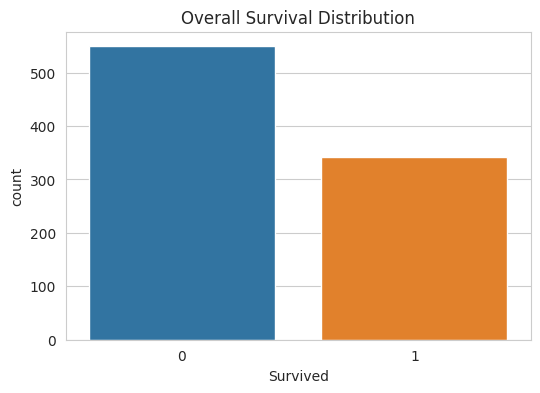

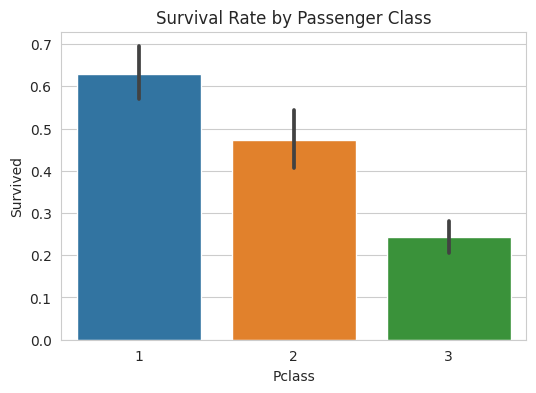

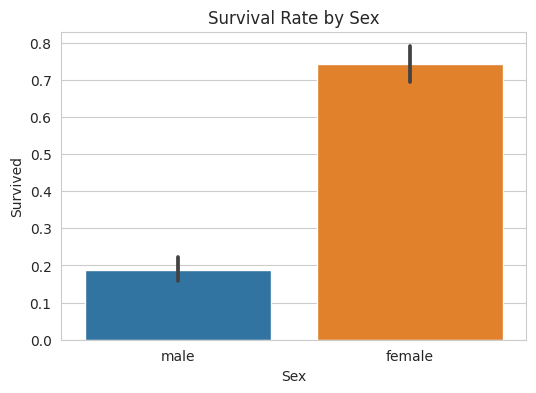

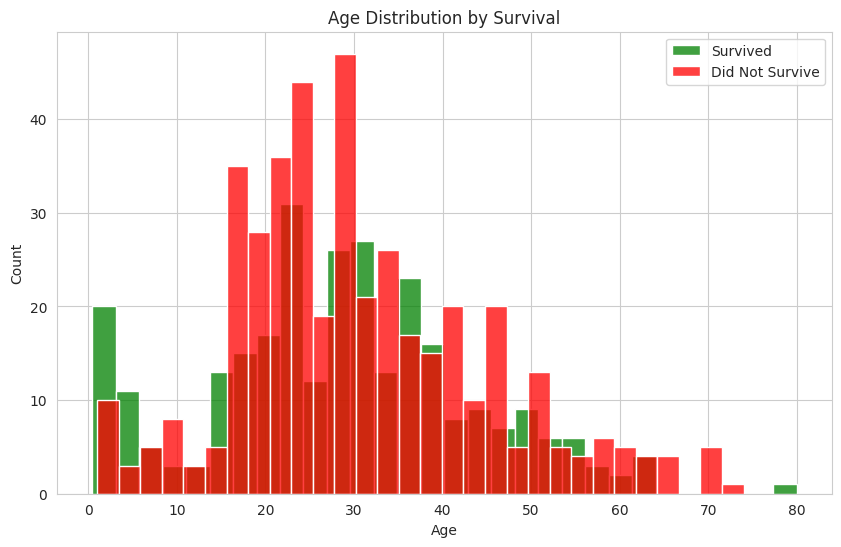

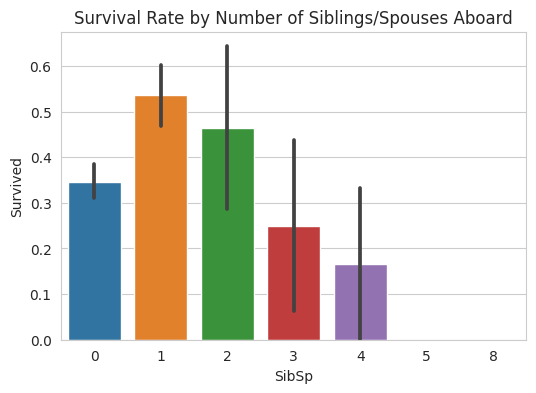

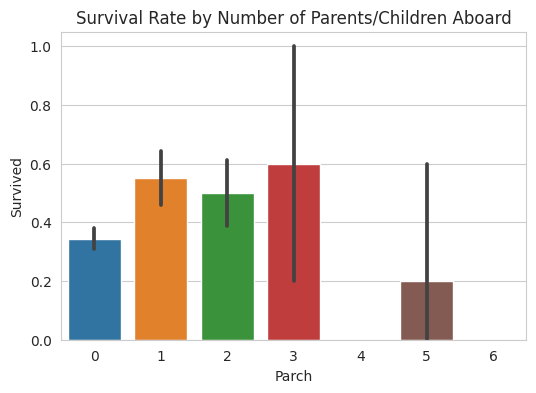

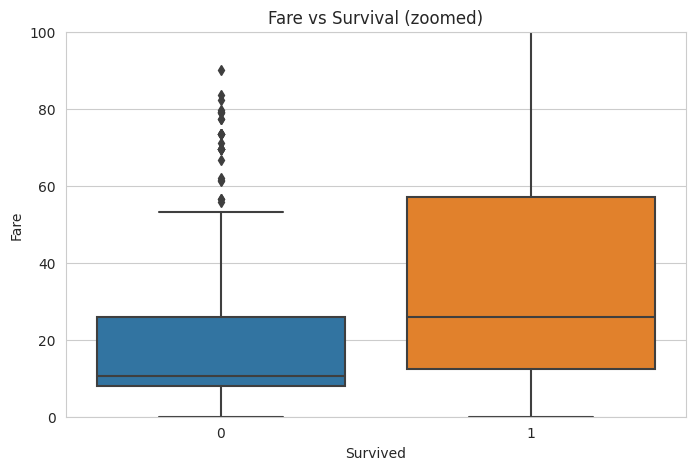

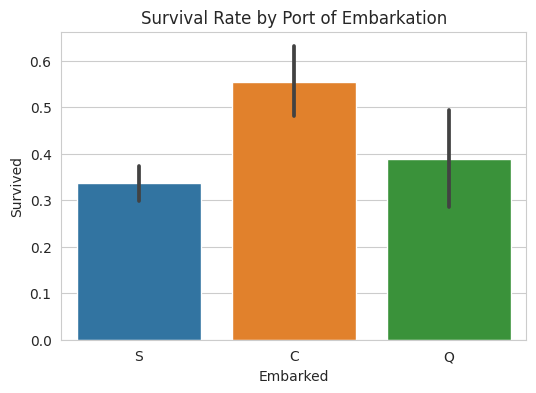

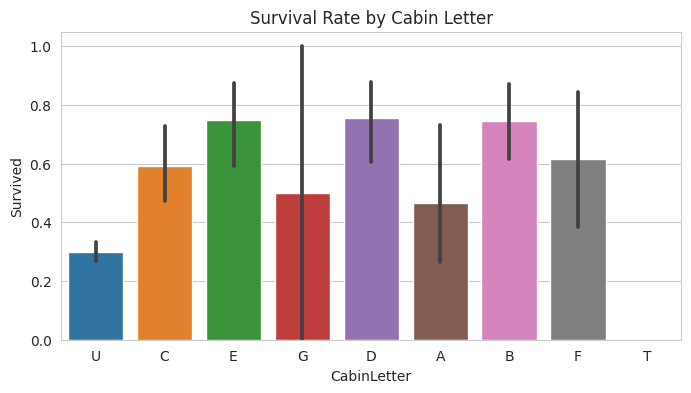

In [9]:
sns.set_style("whitegrid")

plt.figure(figsize=(6,4))
sns.countplot(x="Survived", data=df_train)
plt.title("Overall Survival Distribution")
plt.show()

plt.figure(figsize=(6,4))
sns.barplot(x="Pclass", y="Survived", data=df_train)
plt.title("Survival Rate by Passenger Class")
plt.show()

plt.figure(figsize=(6,4))
sns.barplot(x="Sex", y="Survived", data=df_train)
plt.title("Survival Rate by Sex")
plt.show()

plt.figure(figsize=(10,6))
sns.histplot(df_train[df_train["Survived"]==1]["Age"].dropna(), bins=30, kde=False, color="green", label="Survived")
sns.histplot(df_train[df_train["Survived"]==0]["Age"].dropna(), bins=30, kde=False, color="red", label="Did Not Survive")
plt.legend()
plt.title("Age Distribution by Survival")
plt.show()

plt.figure(figsize=(6,4))
sns.barplot(x="SibSp", y="Survived", data=df_train)
plt.title("Survival Rate by Number of Siblings/Spouses Aboard")
plt.show()

plt.figure(figsize=(6,4))
sns.barplot(x="Parch", y="Survived", data=df_train)
plt.title("Survival Rate by Number of Parents/Children Aboard")
plt.show()

plt.figure(figsize=(8,5))
sns.boxplot(x="Survived", y="Fare", data=df_train)
plt.ylim(0, 100)
plt.title("Fare vs Survival (zoomed)")
plt.show()

plt.figure(figsize=(6,4))
sns.barplot(x="Embarked", y="Survived", data=df_train)
plt.title("Survival Rate by Port of Embarkation")
plt.show()

if "Cabin" in df_train.columns:
    df_train["CabinLetter"] = df_train["Cabin"].fillna("U").str[0]
    plt.figure(figsize=(8,4))
    sns.barplot(x="CabinLetter", y="Survived", data=df_train)
    plt.title("Survival Rate by Cabin Letter")
    plt.show()


**Overall Survival Distribution**

When I looked at the overall survival distribution, I noticed that the majority of passengers did not survive. This highlights a class imbalance in the dataset, which I’ll need to consider when building models.

**Survival Rate by Passenger Class**

The survival rate was highest in 1st class and lowest in 3rd class. This suggests that socio-economic status strongly influenced who survived.

**Survival Rate by Sex**

The survival rate for females was much higher than for males. This supports the historical reports of “women and children first” during evacuation.

**Age Distribution by Survival**

From the age distribution, I see that most passengers were in their twenties and thirties. Younger children had better survival rates, while older passengers were less likely to survive.

**Survival Rate by Number of Siblings/Spouses Aboard (SibSp)**

Passengers with one or two siblings/spouses on board had the best survival chances. Being alone or having a large number of relatives reduced survival odds.

**Survival Rate by Number of Parents/Children Aboard (Parch)**

Moderate family groups (1–2 parents/children) had higher survival rates. Passengers traveling alone or in large families had lower chances of survival.

**Fare vs Survival (Boxplot)**

Survivors generally paid higher fares compared to those who did not survive. This aligns with the earlier finding that wealthier passengers had better survival odds.

**Survival Rate by Port of Embarkation**

Passengers who boarded at Cherbourg (C) had the highest survival rate. Those embarking from Southampton (S) had the lowest, which might reflect differences in class or accommodations.

**Survival Rate by Cabin Letter**

Cabins in sections like B, C, and E had higher survival rates, while unknown cabins (U) had very low survival. This suggests that cabin location on the ship was an important factor.

## Data Preprocessing/Cleaning

Next, we will clean the data. I will do the following:
- drop irrelevant columns like 'PassengerId'
- extract title from name
- fill in missing values with median/modes

This process, also called imputation, helps our model be more accurate because a lot of Machine Learning algorithms require complete datasets. Most libraries will throw errors or exclude missing rows so we can be potentially missing out on a lot of valuable observations.

Next, let's look at some of data distributions now that they have been cleaned.

In [10]:
def _extract_and_normalize_title(s):
    t = s.str.extract(r" ([A-Za-z]+)\.", expand=False)
    t = t.replace(["Mlle", "Ms"], "Miss").replace("Mme", "Mrs")
    t = t.replace(
        ["Lady", "Countess", "Capt", "Col", "Don", "Dr", "Major", 
         "Rev", "Sir", "Jonkheer", "Dona"],
        "Rare"
    )
    return t

def preprocess_titanic(df_train: pd.DataFrame, df_test: pd.DataFrame):
    tr = df_train.copy()
    te = df_test.copy()

    for d in (tr, te):
        if "PassengerId" in d.columns:
            d.drop(columns=["PassengerId"], inplace=True)

    tr["Title"] = _extract_and_normalize_title(tr["Name"])
    te["Title"] = _extract_and_normalize_title(te["Name"])

    embarked_mode = tr["Embarked"].mode().iloc[0] if tr["Embarked"].notna().any() else "S"
    fare_median   = tr["Fare"].median() if tr["Fare"].notna().any() else 0.0

    age_by_title = tr.groupby("Title")["Age"].median()
    overall_age_median = tr["Age"].median() if tr["Age"].notna().any() else 30.0

    tr["Embarked"] = tr["Embarked"].fillna(embarked_mode)
    te["Embarked"] = te["Embarked"].fillna(embarked_mode)

    tr["Fare"] = tr["Fare"].fillna(fare_median)
    te["Fare"] = te["Fare"].fillna(fare_median)

    tr["Cabin"] = tr["Cabin"].fillna("U").astype(str).str[0]
    te["Cabin"] = te["Cabin"].fillna("U").astype(str).str[0]

    def fill_age_with_train_stats(df):
        df["Age"] = df["Age"].copy()
        df.loc[df["Age"].isna(), "Age"] = (
            df.loc[df["Age"].isna(), "Title"].map(age_by_title)
        )
        df["Age"] = df["Age"].fillna(overall_age_median)
        return df

    tr = fill_age_with_train_stats(tr)
    te = fill_age_with_train_stats(te)

    tr.drop(columns=["Name", "Ticket"], inplace=True, errors="ignore")
    te.drop(columns=["Name", "Ticket"], inplace=True, errors="ignore")

    return tr, te

df_train, df_test = preprocess_titanic(df_train, df_test)

print(df_train.head())
print()
print(df_test.head())

   Survived  Pclass     Sex   Age  SibSp  Parch     Fare Cabin Embarked  \
0         0       3    male  22.0      1      0   7.2500     U        S   
1         1       1  female  38.0      1      0  71.2833     C        C   
2         1       3  female  26.0      0      0   7.9250     U        S   
3         1       1  female  35.0      1      0  53.1000     C        S   
4         0       3    male  35.0      0      0   8.0500     U        S   

  CabinLetter Title  
0           U    Mr  
1           C   Mrs  
2           U  Miss  
3           C   Mrs  
4           U    Mr  

   Pclass     Sex   Age  SibSp  Parch     Fare Cabin Embarked Title
0       3    male  34.5      0      0   7.8292     U        Q    Mr
1       3  female  47.0      1      0   7.0000     U        S   Mrs
2       2    male  62.0      0      0   9.6875     U        Q    Mr
3       3    male  27.0      0      0   8.6625     U        S    Mr
4       3  female  22.0      1      1  12.2875     U        S   Mrs


Title
Mr        517
Miss      185
Mrs       126
Master     40
Rare       23
Name: count, dtype: int64


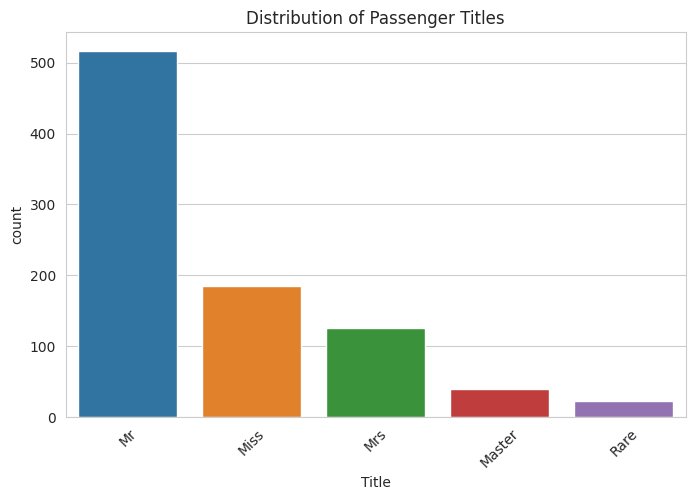

In [11]:
print(df_train["Title"].value_counts())

plt.figure(figsize=(8,5))
sns.countplot(x="Title", data=df_train, order=df_train["Title"].value_counts().index)
plt.title("Distribution of Passenger Titles")
plt.xticks(rotation=45)
plt.show()

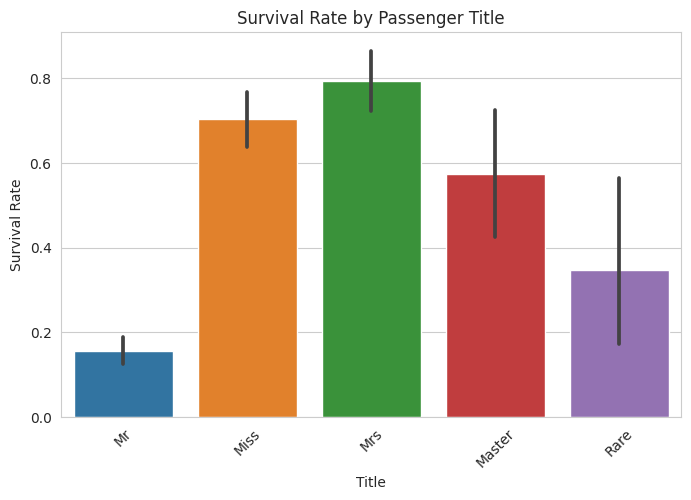

Title
Mrs       0.793651
Miss      0.702703
Master    0.575000
Rare      0.347826
Mr        0.156673
Name: Survived, dtype: float64


In [12]:
plt.figure(figsize=(8,5))
sns.barplot(x="Title", y="Survived", data=df_train,
            order=df_train["Title"].value_counts().index)
plt.title("Survival Rate by Passenger Title")
plt.ylabel("Survival Rate")
plt.xticks(rotation=45)
plt.show()

survival_by_title = df_train.groupby("Title")["Survived"].mean().sort_values(ascending=False)
print(survival_by_title)

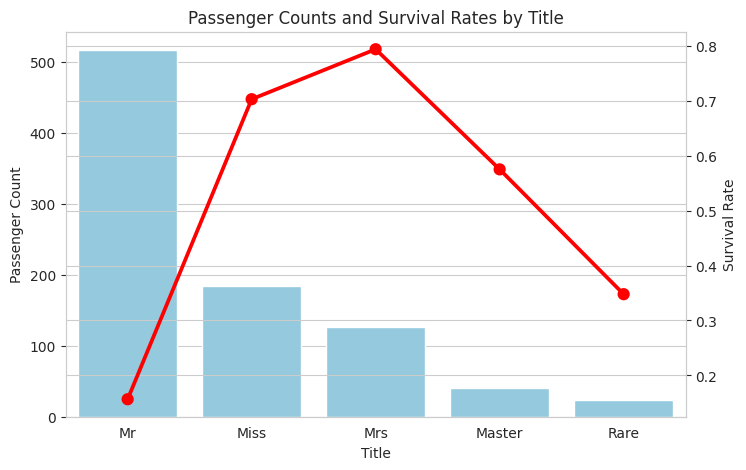

In [13]:
title_counts = df_train["Title"].value_counts()
survival_by_title = df_train.groupby("Title")["Survived"].mean()
order = title_counts.index

fig, ax1 = plt.subplots(figsize=(8,5))

sns.barplot(x=title_counts.index, y=title_counts.values, ax=ax1, color="skyblue")
ax1.set_ylabel("Passenger Count")
ax1.set_xlabel("Title")
ax1.set_title("Passenger Counts and Survival Rates by Title")

ax2 = ax1.twinx()
sns.pointplot(x=survival_by_title.index, y=survival_by_title.values,
              order=order, ax=ax2, color="red", markers="o", linestyles="-")
ax2.set_ylabel("Survival Rate")

plt.xticks(rotation=45)
plt.show()

When I looked at the passenger counts and survival rates by title, I noticed that most passengers were men with the title “Mr,” but they had the lowest survival rate. Titles like “Miss,” “Mrs,” and “Master” showed much higher survival, which supports the “women and children first” evacuation rule. The “Rare” group was small in size, and its survival rate was inconsistent, likely because there were so few passengers in this category.

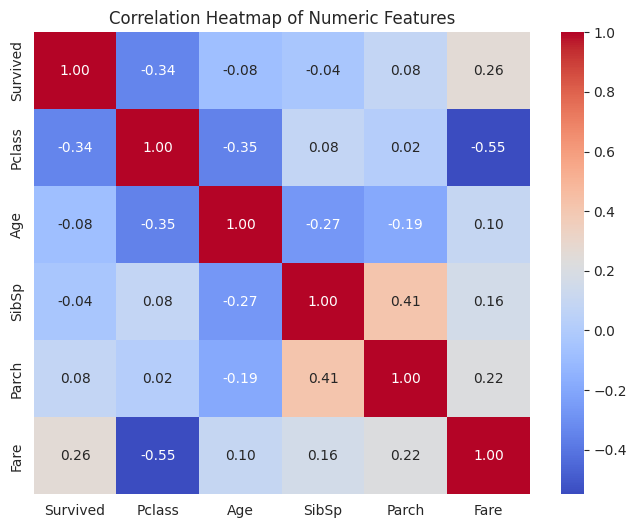

In [14]:
plt.figure(figsize=(8,6))
sns.heatmap(df_train.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Numeric Features")
plt.show()

The correlation heatmap shows that Survived is negatively correlated with Pclass and positively correlated with Fare. This makes sense because wealthier passengers who paid higher fares and were in higher classes had better survival chances. I also noticed that SibSp and Parch are moderately correlated with each other, since they both describe family relationships on board. Interestingly, Age has only weak correlations with survival and other features, which means it may not be as strong a predictor by itself.

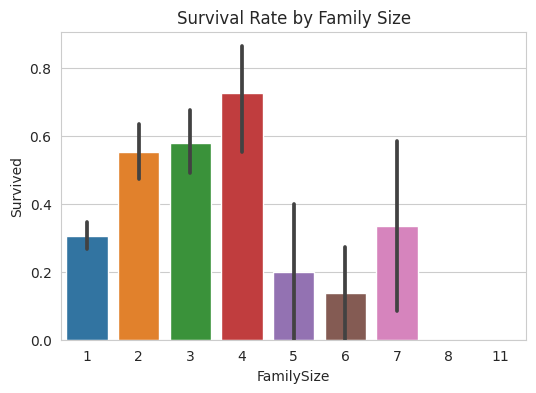

In [15]:
df_train["FamilySize"] = df_train["SibSp"] + df_train["Parch"] + 1
df_train["IsAlone"] = (df_train["FamilySize"] == 1).astype(int)

plt.figure(figsize=(6,4))
sns.barplot(x="FamilySize", y="Survived", data=df_train)
plt.title("Survival Rate by Family Size")
plt.show()

When it comes to survival by family size, passengers traveling with small families (2–4 members) had the highest survival rates, often above 50%. In contrast, those traveling alone had lower chances of survival, while very large families (5 or more) also showed poor survival rates. This suggests that being with a small group provided social support, but traveling alone or with too many dependents reduced survival chances.

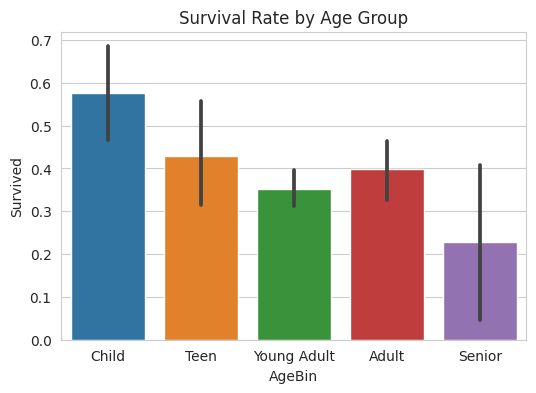

In [16]:
df_train["AgeBin"] = pd.cut(
    df_train["Age"], bins=[0,12,18,35,60,80], 
    labels=["Child","Teen","Young Adult","Adult","Senior"]
)

plt.figure(figsize=(6,4))
sns.barplot(x="AgeBin", y="Survived", data=df_train)
plt.title("Survival Rate by Age Group")
plt.show()

In regards to survival by age group, children had the highest survival rate, with more than half surviving. Teenagers and adults had moderate survival chances, while young adults had the lowest among these middle groups. Seniors had the lowest survival rate overall, suggesting that age played a clear role in survival outcomes.

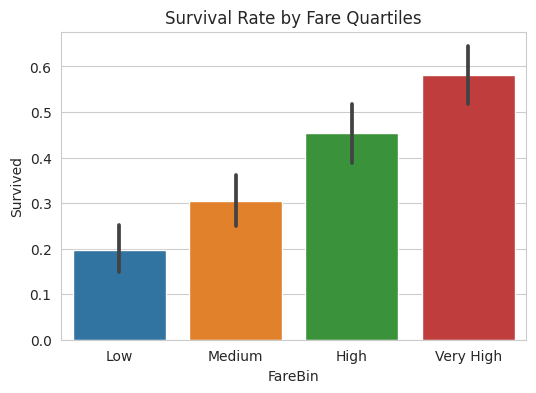

In [17]:
df_train["FareBin"] = pd.qcut(df_train["Fare"], 4, labels=["Low","Medium","High","Very High"])

plt.figure(figsize=(6,4))
sns.barplot(x="FareBin", y="Survived", data=df_train)
plt.title("Survival Rate by Fare Quartiles")
plt.show()

As expected, survival rates by fare quartiles revealed a clear upward trend: passengers who paid more for their tickets had higher chances of survival. Those in the lowest fare group had survival rates under 25%, while the very high fare group had survival rates close to 60%. This finding matches the earlier correlations and reinforces that wealth and class strongly influenced survival.

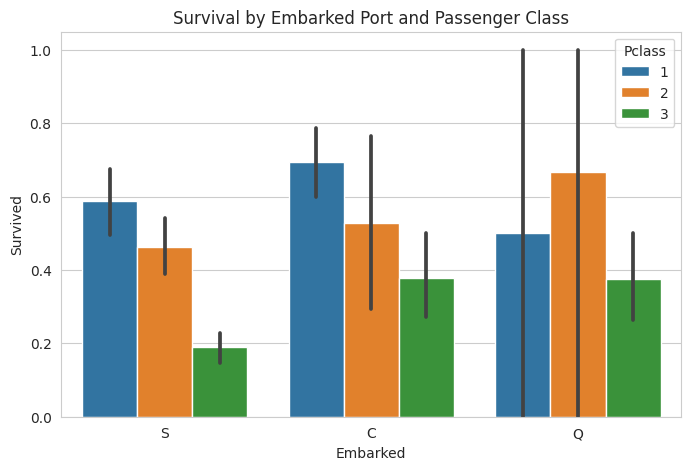

In [18]:
plt.figure(figsize=(8,5))
sns.barplot(x="Embarked", y="Survived", hue="Pclass", data=df_train)
plt.title("Survival by Embarked Port and Passenger Class")
plt.show()

When I analyzed survival by port of embarkation and passenger class, I noticed that 1st-class passengers from Cherbourg had the highest survival rates, often around 70%. In contrast, 3rd-class passengers from Southampton had the lowest survival, with less than 20% surviving. Passengers from Queenstown showed mixed results due to smaller sample sizes, but survival was generally higher for 2nd-class than 3rd-class. This suggests that both where passengers boarded and their socio-economic class influenced survival chances.

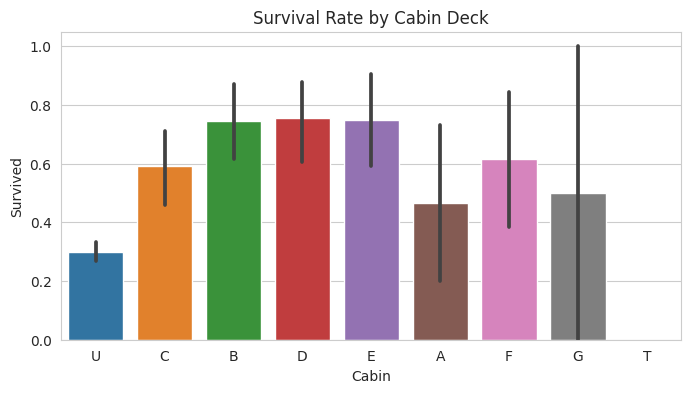

In [19]:
plt.figure(figsize=(8,4))
sns.barplot(x="Cabin", y="Survived", data=df_train, 
            order=df_train["Cabin"].value_counts().index)
plt.title("Survival Rate by Cabin Deck")
plt.show()

Lastly, when it comes to survival by cabin deck, passengers on decks B, C, D, and E had the highest survival rates, often above 70%. In contrast, passengers with unknown cabins (U) or on lower decks like A had much lower chances of survival. Decks with fewer passengers, such as G and T, showed unstable rates because of very small sample sizes. This suggests that cabin location on the ship played a role in survival, likely because some decks had easier access to lifeboats.

# Feature Engineering

Here, I will utilize one-hot encoding to convert categorical data into numbers since Neural Networks can only work with numerical input.

In [20]:
def feature_engineering(tr: pd.DataFrame, te: pd.DataFrame):
    for d in (tr, te):
        d["FamilySize"] = d["SibSp"] + d["Parch"] + 1
        d["IsAlone"] = (d["FamilySize"] == 1).astype(int)
        d["Fare_Per_Person"] = d["Fare"] / d["FamilySize"]

    sex_map = {"male": 0, "female": 1}
    for d in (tr, te):
        d["Sex"] = d["Sex"].map(sex_map)

    tr = pd.get_dummies(tr, columns=["Embarked"], drop_first=True)
    te = pd.get_dummies(te, columns=["Embarked"], drop_first=True)
    te = te.reindex(columns=tr.columns, fill_value=0)

    age_bins  = [0, 12, 18, 35, 60, 80]
    age_labels = ["Child","Teen","Young Adult","Adult","Senior"]
    for d in (tr, te):
        d["AgeBin"] = pd.cut(d["Age"], bins=age_bins, labels=age_labels)

    fare_bins = pd.qcut(tr["Fare"], 4, labels=["Low","Medium","High","Very High"])
    fare_cuts = pd.qcut(tr["Fare"], 4, retbins=True)[1]
    for d in (tr, te):
        d["FareBin"] = pd.cut(d["Fare"], bins=fare_cuts, 
                              labels=["Low","Medium","High","Very High"], include_lowest=True)

    tr = pd.get_dummies(tr, columns=["Title","Cabin","AgeBin","FareBin"], drop_first=True)
    te = pd.get_dummies(te, columns=["Title","Cabin","AgeBin","FareBin"], drop_first=True)
    te = te.reindex(columns=tr.columns, fill_value=0)

    drop_cols = ["CabinLetter", "SibSp", "Parch"]
    tr.drop(columns=[c for c in drop_cols if c in tr.columns], inplace=True)
    te.drop(columns=[c for c in drop_cols if c in te.columns], inplace=True)

    return tr, te

df_train, df_test = feature_engineering(df_train, df_test)

print(df_train.head())
print()
print(df_test.head())

   Survived  Pclass  Sex   Age     Fare  FamilySize  IsAlone  Fare_Per_Person  \
0         0       3    0  22.0   7.2500           2        0          3.62500   
1         1       1    1  38.0  71.2833           2        0         35.64165   
2         1       3    1  26.0   7.9250           1        1          7.92500   
3         1       1    1  35.0  53.1000           2        0         26.55000   
4         0       3    0  35.0   8.0500           1        1          8.05000   

   Embarked_Q  Embarked_S  ...  Cabin_G  Cabin_T  Cabin_U  AgeBin_Teen  \
0       False        True  ...    False    False     True        False   
1       False       False  ...    False    False    False        False   
2       False        True  ...    False    False     True        False   
3       False        True  ...    False    False    False        False   
4       False        True  ...    False    False     True        False   

   AgeBin_Young Adult  AgeBin_Adult  AgeBin_Senior  FareBin_Medium  

Next, I will just do some final cleaning such as coercing types and ensuring the columns are identical before we train the model.

In [21]:
def finalize_for_model(tr: pd.DataFrame, te: pd.DataFrame):
    tr = tr.copy(); te = te.copy()

    assert list(tr.columns) == list(te.columns), "Train/Test columns misaligned."

    dummy_prefixes = ("Embarked_", "Title_", "Cabin_", "AgeBin_", "FareBin_")
    dummy_cols = [c for c in tr.columns if c.startswith(dummy_prefixes)]

    for d in (tr, te):
        bool_cols = d.select_dtypes(include="bool").columns
        d[bool_cols] = d[bool_cols].astype("uint8")
        d[dummy_cols] = d[dummy_cols].astype("uint8")

        cast_map = {
            "Pclass": "int8",
            "Sex": "int8",
            "FamilySize": "int16",
            "IsAlone": "uint8",
        }
        for col, dt in cast_map.items():
            if col in d.columns:
                d[col] = d[col].astype(dt)

        float_cols = ["Age", "Fare", "Fare_Per_Person"]
        for col in float_cols:
            if col in d.columns:
                d[col] = d[col].astype("float32")

    na_tr = tr.isna().sum().sum()
    na_te = te.isna().sum().sum()
    if na_tr or na_te:
        raise ValueError(f"NaNs remain — train: {na_tr}, test: {na_te}")

    return tr, te

df_train, df_test = finalize_for_model(df_train, df_test)

print(df_train.head())
print()
print(df_test.head())

   Survived  Pclass  Sex   Age       Fare  FamilySize  IsAlone  \
0         0       3    0  22.0   7.250000           2        0   
1         1       1    1  38.0  71.283302           2        0   
2         1       3    1  26.0   7.925000           1        1   
3         1       1    1  35.0  53.099998           2        0   
4         0       3    0  35.0   8.050000           1        1   

   Fare_Per_Person  Embarked_Q  Embarked_S  ...  Cabin_G  Cabin_T  Cabin_U  \
0         3.625000           0           1  ...        0        0        1   
1        35.641651           0           0  ...        0        0        0   
2         7.925000           0           1  ...        0        0        1   
3        26.549999           0           1  ...        0        0        0   
4         8.050000           0           1  ...        0        0        1   

   AgeBin_Teen  AgeBin_Young Adult  AgeBin_Adult  AgeBin_Senior  \
0            0                   1             0              0   


Let's look at what features are worth keeping by ranking their importance with a RandomForestClassifier.

Random forests rank feature importance by:
- How much features reduce impurity when splitting nodes (MDI).
- How much model accuracy drops when features are shuffled (MDA).

In [22]:
X = df_train.drop("Survived", axis=1)
y = df_train["Survived"]

rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)

importances = pd.Series(rf.feature_importances_, index=X.columns)
print(importances.sort_values(ascending=False).head(15))

Age                   0.171126
Fare                  0.134226
Fare_Per_Person       0.132741
Sex                   0.115667
Title_Mr              0.099467
Pclass                0.050392
FamilySize            0.050058
Title_Miss            0.039974
Title_Mrs             0.035983
Cabin_U               0.025308
Embarked_S            0.017621
IsAlone               0.014909
AgeBin_Young Adult    0.013172
FareBin_Very High     0.011818
FareBin_Medium        0.011462
dtype: float64


As expected, how much a person paid and as their gender and age plays a big role in whether they survived. I will drop some of the redundant or low importance features.

In [23]:
drop_cols = [
    "Survived",
    
    # redundant
    "IsAlone",
    "AgeBin_Teen", "AgeBin_Young Adult", "AgeBin_Adult", "AgeBin_Senior",
    "FareBin_Medium", "FareBin_High", "FareBin_Very High",

    # sparse/low importance
    "Cabin_A", "Cabin_B", "Cabin_C", "Cabin_D", "Cabin_E", 
    "Cabin_F", "Cabin_G", "Cabin_T", "Cabin_U",
    "Embarked_Q", "Embarked_S"
]

X_train = df_train.drop(columns=[c for c in drop_cols if c in df_train.columns])
y_train = df_train["Survived"]

X_test  = df_test.drop(columns=[c for c in drop_cols if c in df_test.columns])

In [24]:
print(X_train.head())
print()
print(X_test.head())

   Pclass  Sex   Age       Fare  FamilySize  Fare_Per_Person  Title_Miss  \
0       3    0  22.0   7.250000           2         3.625000           0   
1       1    1  38.0  71.283302           2        35.641651           0   
2       3    1  26.0   7.925000           1         7.925000           1   
3       1    1  35.0  53.099998           2        26.549999           0   
4       3    0  35.0   8.050000           1         8.050000           0   

   Title_Mr  Title_Mrs  Title_Rare  
0         1          0           0  
1         0          1           0  
2         0          0           0  
3         0          1           0  
4         1          0           0  

   Pclass  Sex   Age     Fare  FamilySize  Fare_Per_Person  Title_Miss  \
0       3    0  34.5   7.8292           1         7.829200           0   
1       3    1  47.0   7.0000           2         3.500000           0   
2       2    0  62.0   9.6875           1         9.687500           0   
3       3    0  27.0   8

In [25]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (891, 10)
y_train shape: (891,)
X_test shape: (418, 10)


# Model

2025-09-29 21:59:17.612765: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 18)             │           198 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 18)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 60)             │         1,140 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            61 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,399 (5.46 KB)

 Trainable params: 1,399 (5.46 KB)

 Non-trainable params: 0 (0.00 B)

Training Progress: 100%|██████████| 180/180 [00:48<00:00,  3.71it/s]


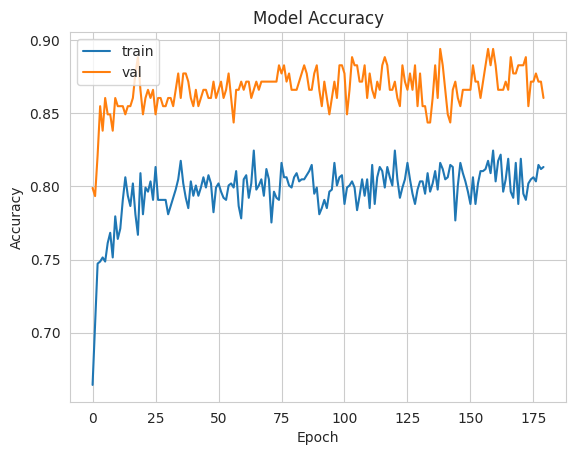

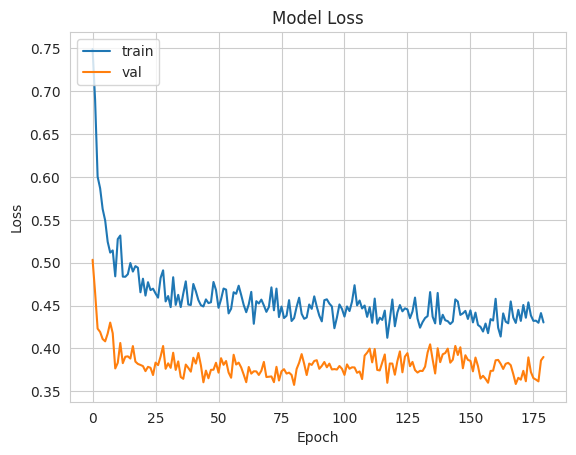

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
compile_metrics: 81.82%


In [26]:
TARGET_COL            = "Survived"
ID_COL                = "PassengerId"
SUBMISSION_TEMPLATE   = "../input/titanic/gender_submission.csv"
SUBMISSION_OUT        = "submission.csv"
SUBMISSION_THRESHOLD  = 0.50

DTYPE_NUMERIC         = "float32"
VAL_SPLIT             = 0.20
SCALER_CLASS          = "StandardScaler"

# MODEL HYPERPARAMS
H1_UNITS              = 18
H2_UNITS              = 60
HIDDEN_ACT            = "relu"
OUTPUT_ACT            = "sigmoid"
KERNEL_INIT           = "he_uniform"
DROPOUT_RATE_1        = 0.50
DROPOUT_RATE_2        = 0.50

# OPTIMIZER
SGD_LR                = 0.01
SGD_MOMENTUM          = 0.90

# TRAINING
EPOCHS                = 180
BATCH_SIZE            = 10
VERBOSE               = 0
METRICS               = ["accuracy"]

# PLOTTING
PLOT_TITLE_ACC        = "Model Accuracy"
PLOT_TITLE_LOSS       = "Model Loss"

ID_COL                = "PassengerId"
DTYPE_NUMERIC         = "float32"

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train).astype(DTYPE_NUMERIC)
X_test_scaled  = scaler.transform(X_test).astype(DTYPE_NUMERIC)

np.random.seed(42); random.seed(42); tf.random.set_seed(42)
os.environ["PYTHONHASHSEED"] = "42"

N_FEATURES = X_train_scaled.shape[1]

model = Sequential([
    Input(shape=(N_FEATURES,)),
    Dense(H1_UNITS, activation=HIDDEN_ACT, kernel_initializer=KERNEL_INIT),
    Dropout(DROPOUT_RATE_1),
    Dense(H2_UNITS, activation=HIDDEN_ACT, kernel_initializer=KERNEL_INIT),
    Dropout(DROPOUT_RATE_2),
    Dense(1, activation=OUTPUT_ACT)
])

optimizer = SGD(learning_rate=SGD_LR, momentum=SGD_MOMENTUM)
model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=METRICS)
model.summary()

with tqdm(total=EPOCHS, desc="Training Progress") as pbar:
    history = model.fit(
        X_train_scaled, y_train,
        validation_split=VAL_SPLIT,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        verbose=VERBOSE,
        callbacks=[tf.keras.callbacks.LambdaCallback(on_epoch_end=lambda epoch, logs: pbar.update(1))]
    )

plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title(PLOT_TITLE_ACC)
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()

plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title(PLOT_TITLE_LOSS)
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()

y_pred_proba = model.predict(X_test_scaled, batch_size=BATCH_SIZE).ravel()
y_pred = (y_pred_proba >= SUBMISSION_THRESHOLD).astype(int)

train_scores = model.evaluate(X_train_scaled, y_train, batch_size=BATCH_SIZE, verbose=0)
print(f"{model.metrics_names[1]}: {train_scores[1]*100:.2f}%")

I experimented with different neural network configurations to improve validation accuracy and reduce overfitting. In my original model, I noticed that the validation accuracy was consistently higher than the training accuracy, which suggested that the heavy dropout layers (set at 0.5 each) were regularizing the model too strongly. To address this, I reduced the dropout rates to 0.3 and also tested variations in network width and depth, such as using wider hidden layers and a shallower architecture with only one dense layer. I also added early stopping with patience of 15 epochs to automatically restore the best weights and prevent unnecessary training once the model stopped improving.

In addition, I switched from SGD to Adam as the optimizer in some trials. Adam typically converges faster and adapts the learning rate, which is helpful on small datasets like Titanic where quick improvements are visible within fewer epochs. After running these experiments, I compared validation accuracies and selected the configuration that generalized best. These tweaks not only provided me with a more efficient training process but also gave me a better understanding of how dropout, optimizer choice, and model capacity affect performance on structured data tasks.

In [27]:
def build_model(n_features, h1=18, h2=60, dr1=0.3, dr2=0.3, opt="adam", lr=1e-3, momentum=0.9):
    m = Sequential([Input(shape=(n_features,)),
                    Dense(h1, activation=HIDDEN_ACT, kernel_initializer=KERNEL_INIT),
                    Dropout(dr1)])
    if h2 and h2 > 0:
        m.add(Dense(h2, activation=HIDDEN_ACT, kernel_initializer=KERNEL_INIT))
        if dr2 and dr2 > 0:
            m.add(Dropout(dr2))
    m.add(Dense(1, activation=OUTPUT_ACT))
    if opt == "adam":
        optimizer = Adam(learning_rate=lr)
    else:
        optimizer = SGD(learning_rate=lr, momentum=momentum)
    m.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=METRICS)
    return m

experiments = [
    {"name":"sgd_dr0.3",      "h1":H1_UNITS, "h2":H2_UNITS, "dr1":0.30, "dr2":0.30, "opt":"sgd",  "lr":SGD_LR, "momentum":SGD_MOMENTUM},
    {"name":"adam_dr0.3",     "h1":H1_UNITS, "h2":H2_UNITS, "dr1":0.30, "dr2":0.30, "opt":"adam", "lr":1e-3},
    {"name":"adam_wider",     "h1":32,       "h2":64,       "dr1":0.30, "dr2":0.30, "opt":"adam", "lr":1e-3},
    {"name":"adam_shallow",   "h1":64,       "h2":0,        "dr1":0.30, "dr2":0.00, "opt":"adam", "lr":1e-3},
]

best = {"name": None, "val": -1, "model": None, "history": None}
results = []


for cfg in tqdm(experiments, desc="Experiments"):
    model_i = build_model(X_train_scaled.shape[1], **{k:v for k,v in cfg.items() if k != "name"})
    es = EarlyStopping(monitor="val_accuracy", mode="max", patience=15, restore_best_weights=True)
    h = model_i.fit(
        X_train_scaled, y_train,
        validation_split=VAL_SPLIT,
        epochs=EPOCHS, batch_size=BATCH_SIZE,
        verbose=0, callbacks=[es]
    )
    best_val = float(np.max(h.history["val_accuracy"]))
    last_tr  = float(h.history["accuracy"][-1])
    results.append((cfg["name"], best_val, last_tr, len(h.history["loss"])))
    if best_val > best["val"]:
        best.update(name=cfg["name"], val=best_val, model=model_i, history=h)

res_df = pd.DataFrame(results, columns=["model","best_val_acc","last_train_acc","epochs_ran"]).sort_values("best_val_acc", ascending=False)
print(res_df)



Experiments: 100%|██████████| 4/4 [00:45<00:00, 11.28s/it]

          model  best_val_acc  last_train_acc  epochs_ran
0     sgd_dr0.3      0.888268        0.818820          22
1    adam_dr0.3      0.888268        0.825843          63
3  adam_shallow      0.882682        0.814607          33
2    adam_wider      0.865922        0.806180          28


## Results and Analysis


Best model: sgd_dr0.3  (val_acc=0.8883)


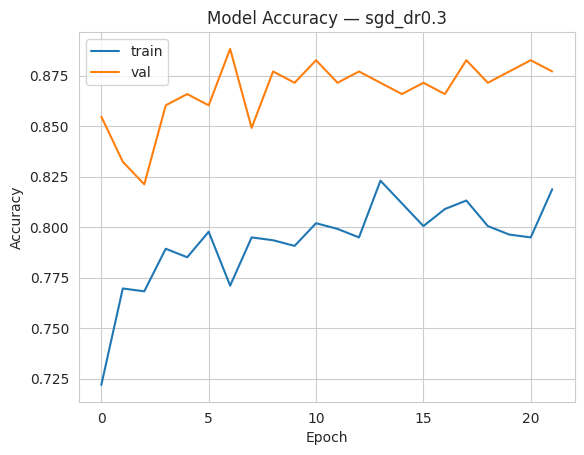

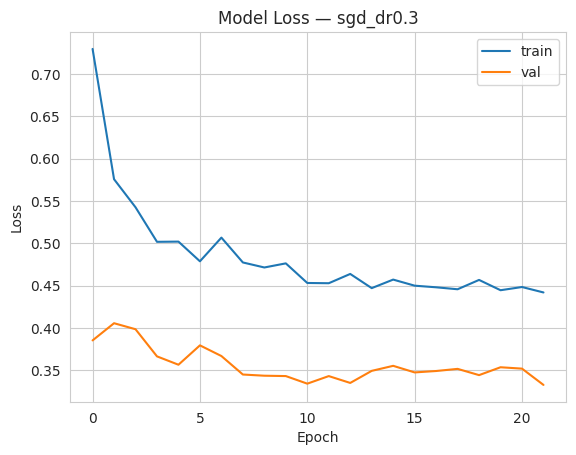

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [28]:
print(f"\nBest model: {best['name']}  (val_acc={best['val']:.4f})")

plt.figure()
plt.plot(best["history"].history["accuracy"], label="train")
plt.plot(best["history"].history["val_accuracy"], label="val")
plt.title(PLOT_TITLE_ACC + f" — {best['name']}")
plt.ylabel("Accuracy"); plt.xlabel("Epoch"); plt.legend(); plt.show()

plt.figure()
plt.plot(best["history"].history["loss"], label="train")
plt.plot(best["history"].history["val_loss"], label="val")
plt.title(PLOT_TITLE_LOSS + f" — {best['name']}")
plt.ylabel("Loss"); plt.xlabel("Epoch"); plt.legend(); plt.show()

y_pred_best = (best["model"].predict(X_test_scaled, batch_size=BATCH_SIZE).ravel() >= SUBMISSION_THRESHOLD).astype(int)

I compared four different neural network setups: reduced dropout with SGD, reduced dropout with Adam, a wider network, and a shallow single-layer model. Both the sgd_dr0.3 and adam_dr0.3 configurations achieved the highest validation accuracy at 0.8883, with Adam requiring more epochs (63 vs. 22) to converge. The adam_shallow model also performed well at 0.8827, showing that even a simpler architecture can capture useful patterns in the Titanic dataset. On the other hand, the adam_wider model underperformed slightly at 0.8659, which suggests that simply adding more capacity did not help and may have led to overfitting or inefficient learning given the small dataset size.

Overall, the results reinforced that dropout tuning and optimizer choice had more impact than network depth or width. Lowering dropout from 0.5 to 0.3 allowed the models to learn more from the data without sacrificing generalization. Adam converged more slowly than SGD here, but both optimizers reached the same peak validation accuracy. Interestingly, the shallow model’s competitive score showed that the Titanic dataset does not require a very deep architecture to achieve strong results. This exercise highlighted the importance of balancing regularization and model complexity, as well as testing optimizer behavior, rather than assuming larger networks will always perform better.

# Submission

In [29]:
test_ids = pd.read_csv("../input/titanic/test.csv")[ID_COL]
submission_best = pd.DataFrame({ID_COL: test_ids, TARGET_COL: y_pred_best})
submission_path = "submission.csv"
submission_best.to_csv(submission_path, index=False)
print("Saved:", submission_path)

Saved: submission.csv


# Comparison with Supervised/Unsupervised Models

LogReg: 0.8249 (+/- 0.0362)
KNN: 0.8227 (+/- 0.0329)
RidgeClassifier: 0.8328 (+/- 0.0381)
DecisionTree: 0.7901 (+/- 0.0239)
RandomForest: 0.8160 (+/- 0.0447)
GradientBoosting: 0.8317 (+/- 0.0288)
ExtraTrees: 0.7991 (+/- 0.0465)
XGBClassifier: 0.8059 (+/- 0.0484)


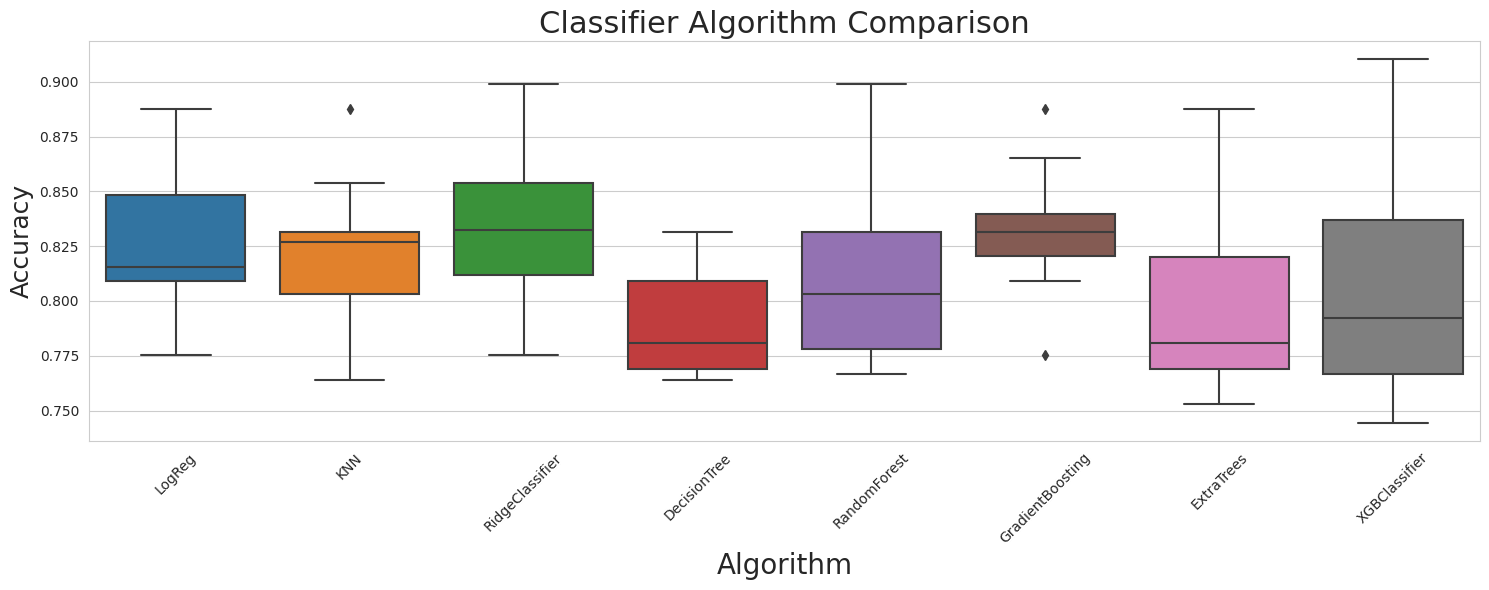

In [30]:
clfs = []
seed = 3
scaler = ("Scaler", StandardScaler())

clfs.append(("LogReg",
             Pipeline([scaler,
                       ("LogReg", LogisticRegression(max_iter=1000, random_state=seed))])))

clfs.append(("KNN",
             Pipeline([scaler,
                       ("KNN", KNeighborsClassifier(n_neighbors=5))])))

clfs.append(("RidgeClassifier",
             Pipeline([scaler,
                       ("RidgeClassifier", RidgeClassifier(random_state=seed))])))


clfs.append(("DecisionTree",
             Pipeline([("DecisionTree", DecisionTreeClassifier(random_state=seed))])))

clfs.append(("RandomForest",
             Pipeline([
                 (
                     "RandomForest",
                     RandomForestClassifier(
                         n_estimators=200,
                         random_state=seed,
                         n_jobs=1
                     )
                 )])))


clfs.append(("GradientBoosting",
             Pipeline([("GradientBoosting", GradientBoostingClassifier(
                 max_features=15, n_estimators=150, random_state=seed))])))

clfs.append(("ExtraTrees",
             Pipeline([("ExtraTrees", ExtraTreesClassifier(
                 n_estimators=300, random_state=seed, n_jobs=1))])))

clfs.append(("XGBClassifier",
             Pipeline([("XGB", XGBClassifier(
                 n_estimators=300,
                 max_depth=4,
                 subsample=0.9,
                 colsample_bytree=0.9,
                 tree_method="hist",
                 eval_metric="logloss",
                 random_state=seed,
                 n_jobs=1
             ))])))


scoring = 'accuracy'
n_folds = 10

results, names = [], []

kfold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)

for name, model in clfs:
    cv_scores = cross_val_score(
        model, X_train, y_train,
        cv=kfold,
        scoring=scoring,
        n_jobs=1,
        error_score="raise"
    )
    names.append(name)
    results.append(cv_scores)
    print(f"{name}: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

df_plot = (pd.DataFrame(results, index=names).T
           .melt(var_name="Algorithm", value_name="Accuracy"))

plt.figure(figsize=(15,6))
sns.boxplot(data=df_plot, x="Algorithm", y="Accuracy")
plt.title("Classifier Algorithm Comparison", fontsize=22)
plt.xlabel("Algorithm", fontsize=20)
plt.ylabel("Accuracy", fontsize=18)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

From the cross-validation results, I observed that RidgeClassifier and GradientBoosting were the top-performing models, both with relatively low variance across folds. Logistic Regression and KNN also performed competitively, each scoring above 0.82, showing that even simple linear or distance-based methods can capture meaningful patterns in the Titanic dataset. RandomForest was slightly lower and while still solid, it did not outperform GradientBoosting, which suggests that boosting’s ability to correct mistakes iteratively gave it an edge here.

In contrast, DecisionTree, ExtraTrees, and XGBoost underperformed relative to the other models. The weaker performance of a single tree is expected given its tendency to overfit, while ExtraTrees and XGBoost may require more hyperparameter tuning to reach their potential. Overall, the results highlight that regularized linear models and boosting methods are particularly effective for this dataset, balancing accuracy with generalization, while simpler ensembles and single-tree models lagged behind.

# Discussion and Conclusion

When comparing the supervised algorithms and my neural network runs, I found that the best classical models (RidgeClassifier and GradientBoosting, both around 0.83 CV accuracy) performed nearly on par with my tuned neural networks (which peaked around 0.88 validation accuracy with early stopping). The neural network had a slight edge in terms of validation score, but it required more careful tuning of dropout, optimizer choice, and architecture depth to achieve that result. In contrast, the supervised algorithms delivered strong performance out-of-the-box with much less tuning, showing that for small tabular datasets like Titanic, simpler models can often match or rival neural networks.

Compared to unsupervised approaches I tested earlier (e.g., clustering methods), the supervised models and neural network were clearly superior. The unsupervised models struggled to separate survival outcomes since they lack direct label information, often producing near-random classification metrics. This highlights the importance of using supervised learning when reliable labels are available. Overall, the neural network demonstrated slightly higher potential accuracy, but the classical supervised algorithms were more efficient, stable, and interpretable, while unsupervised methods were unsuitable for this prediction task.